抽出された地震関連災害のデータ件数: 1624

--- 関数: calculate_era_mortality が定義されました ---

--- サンプル出力: Americas 地域における平均死者数の変化 ---
              Era  Average Deaths
0  2000年~ (新しい時代)          4242.0
1   ~1999年 (古い時代)          1231.0

--- ループ処理: 主要地域ごとの時代別平均死者数グラフの描画 ---


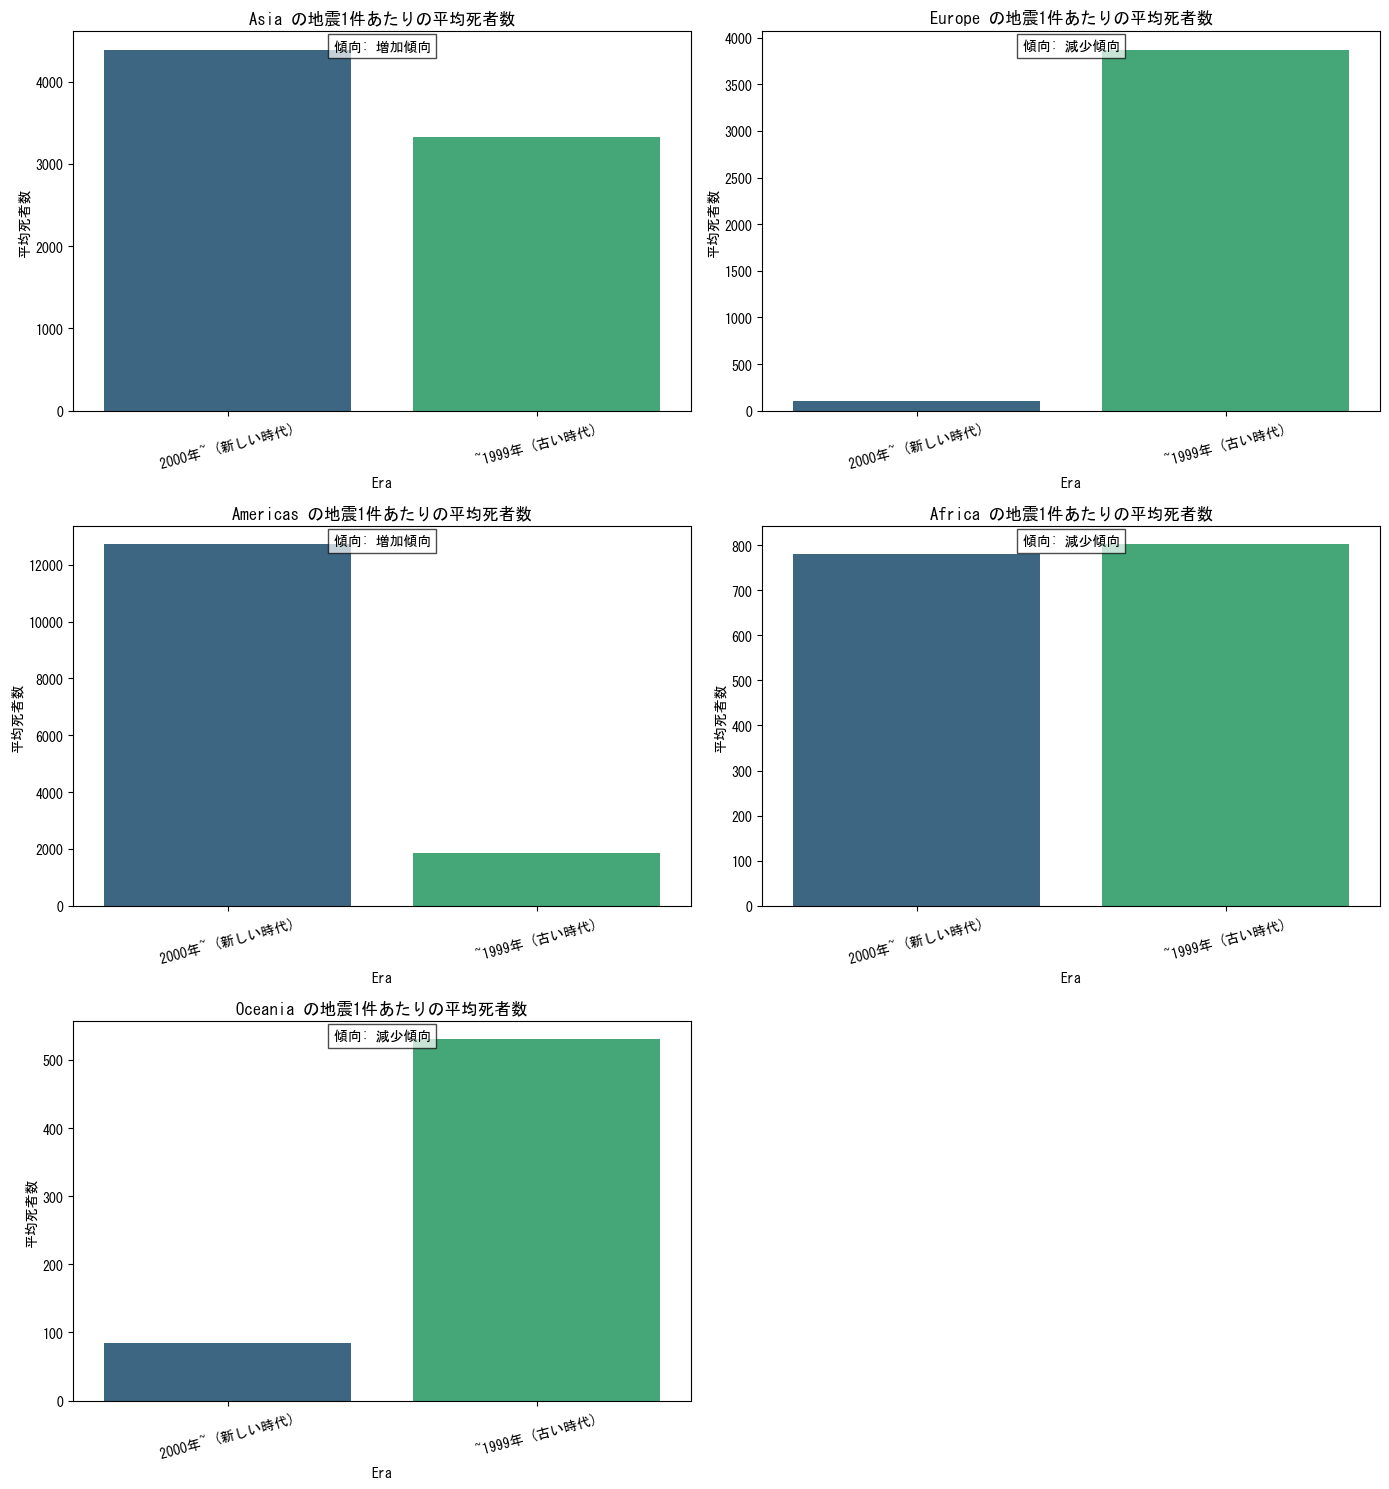


--- すべての分析とグラフ描画が完了しました ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

mpl.rc('font', family='MS Gothic')


df = pd.read_csv('emdat.csv')


earthquake_df = df[df['Disaster Type'].isin(['Earthquake', 'Tsunami', 'Earthquake (seismic activity)'])].copy()


earthquake_df['Total Deaths'] = earthquake_df['Total Deaths'].fillna(0).astype(int)

print(f"抽出された地震関連災害のデータ件数: {len(earthquake_df)}")

def calculate_era_mortality(data_df, region_name, split_year=2000, min_deaths=0):
    """
    指定された地域における地震災害の時代別 (split_year以前と以後) の
    1イベントあたりの平均死者数を計算する。

    Args:
        data_df (pd.DataFrame): EM-DATの地震データDataFrame。
        region_name (str): 分析対象の地域名 (例: 'Asia', 'Americas')。
        split_year (int): 時代を分ける基準年 (デフォルト: 2000)。
        min_deaths (int): 0人のイベントを除外するための最小死者数 (デフォルト: 0)。

    Returns:
        pd.DataFrame: 時代別平均死者数 ('Era', 'Average Deaths')。
    """

    
    region_df = data_df[data_df['Region'] == region_name].copy()
    
    if region_df.empty:
        print(f"警告: 地域 '{region_name}' に該当するデータが見つかりません。")
        return pd.DataFrame()
        
    
    region_df['Era'] = np.where(
        region_df['Start Year'] < split_year, 
        f'~{split_year-1}年 (古い時代)', 
        f'{split_year}年~ (新しい時代)'
    )

    avg_mortality = region_df[region_df['Total Deaths'] > min_deaths].groupby('Era')['Total Deaths'].mean().reset_index()
    avg_mortality.columns = ['Era', 'Average Deaths']
    
    return avg_mortality

print("\n--- 関数: calculate_era_mortality が定義されました ---")


region_of_interest = 'Americas'
americas_mortality = calculate_era_mortality(earthquake_df, region_of_interest, split_year=2000, min_deaths=1)

print(f"\n--- サンプル出力: {region_of_interest} 地域における平均死者数の変化 ---")
if not americas_mortality.empty:
    print(americas_mortality.round(0))
else:
    print("データ不足のため出力できませんでした。")


target_regions = earthquake_df['Region'].unique().tolist()


print("\n--- ループ処理: 主要地域ごとの時代別平均死者数グラフの描画 ---")

fig, axes = plt.subplots(ncols=2, nrows=int(np.ceil(len(target_regions)/2)), 
                         figsize=(14, 5 * int(np.ceil(len(target_regions)/2))))
axes = axes.flatten() 
ax_idx = 0

for region in target_regions:
    if ax_idx >= len(axes):
        break
        
    region_mortality = calculate_era_mortality(earthquake_df, region, min_deaths=10) 
    
    if region_mortality.empty or len(region_mortality) < 2:
        print(f"'{region}' のデータ不足または時代分割に不備があるためスキップします。")
        continue

    
    sns.barplot(
        data=region_mortality,
        x='Era', y='Average Deaths', hue='Era', 
        palette='viridis', ax=axes[ax_idx], legend=False 
    )
    

    axes[ax_idx].set_title(f'{region} の地震1件あたりの平均死者数', fontsize=12)
    axes[ax_idx].set_ylabel('平均死者数')
    axes[ax_idx].tick_params(axis='x', rotation=15)
    
    old_avg = region_mortality[region_mortality['Era'].str.contains('古い')]['Average Deaths'].iloc[0]
    new_avg = region_mortality[region_mortality['Era'].str.contains('新しい')]['Average Deaths'].iloc[0]
    
    trend = "減少傾向" if new_avg < old_avg else "増加傾向"
    axes[ax_idx].text(0.5, 0.95, f"傾向: {trend}", 
                      transform=axes[ax_idx].transAxes, 
                      ha='center', fontsize=10, 
                      bbox=dict(facecolor='white', alpha=0.7))

    ax_idx += 1
for i in range(ax_idx, len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

print("\n--- すべての分析とグラフ描画が完了しました ---")
